In [1]:
import collections
import itertools
import pathlib
import random
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib.patches import Patch
sns.set_context("talk")

In [2]:
db_path = pathlib.Path('instacart.db')

def sql_data(statement):
    conn = sqlite3.Connection(db_path)
    table = pd.read_sql(statement, conn)
    conn.close()
    return table

# Customer Information Analysis

## Total number of orders

In [3]:
statement = 'SELECT * from orders;'
orders =sql_data(statement)
Num_orders = orders.groupby(["user_id"]).agg({'order_id':"count"})
Num_orders.columns = ['total orders']
Num_orders

,total orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


In [4]:
Num_orders.describe()

,total orders
count,206209.000000
mean,15.590367
std,16.654774
min,3.000000
25%,5.000000
50%,9.000000
75%,19.000000
max,99.000000


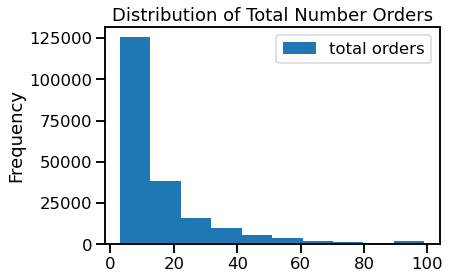

In [5]:
Num_orders.plot(kind='hist')
plt.title("Distribution of Total Number Orders")
plt.show()

## Avg number of items in order

In [6]:
statement = 'SELECT user_id, o.order_id, product_id, reordered from orders o inner join order_details od on o.order_id=od.order_id;'
user_items= sql_data(statement)

In [ ]:
Num_items = user_items.groupby('user_id')['product_id'].count()
Num_order = user_items.groupby('user_id')['order_id'].nunique()
Q3 = pd.concat([Num_items,Num_order],axis=1)
Q3['avg_items_in_order'] = round(Q3['product_id']/Q3['order_id'],1)
Q3.drop(columns=['product_id','order_id'],inplace=True)
Q3.head()

In [ ]:
Q3.describe()

In [ ]:
Q3.plot(kind='hist',bins=25)
plt.title("Distribution of Avg Item Numbers in Orders")
plt.show()

## Percentage of each days’ order

In [ ]:
customer_dow=orders.groupby(["user_id","order_dow"])['order_id'].count().reset_index()
customer_dow['total']= customer_dow.groupby('user_id')['order_id'].transform('sum')
customer_dow['proportion'] = customer_dow['order_id']/customer_dow['total']
customer_dow=customer_dow.pivot(
    index='user_id',
    columns='order_dow',
    values='proportion',
)
customer_dow = customer_dow.fillna(0)
customer_dow.columns = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
customer_dow.head()

## Percentage of customer’s purchase time range
(7am-12pm : morning; 12pm-5pm : afternoon; 5pm-10pm : evening; 10pm-7am : midnight)

In [ ]:
def to_timeperiod(num):
    if 12 > num >= 7:
        return "Morning"
    elif 17 > num >= 12:
        return "Afternoon"
    elif 22 > num >= 17:
        return "Evening"
    else:
        return "Midnight"

orders['period']= orders["order_hour_of_day"].apply(to_timeperiod)

order_period = orders.groupby(["user_id","period"])['order_id'].count().reset_index()
order_period['total']= order_period.groupby('user_id')['order_id'].transform('sum')
order_period['proportion'] = order_period['order_id']/order_period['total']
order_period=order_period.pivot(
    index='user_id',
    columns='period',
    values='proportion')
order_period = order_period.fillna(0)
order_period

## Order frequency (average how many days between each order)

In [ ]:
order_freq = orders.groupby("user_id").agg({"days_since_prior_order":"mean"})
order_freq.columns=["avg_days_since_prior"]
order_freq

## Customer item reorder rate

In [ ]:
groupby_columns = ['user_id']
agg_dict = {
    'reordered': ['sum', 'count'],
}
user_reorder=user_items.groupby(groupby_columns).agg(agg_dict)
user_reorder.columns=['reorder_times','total_times']
user_reorder["reorder_rate"]=user_reorder['reorder_times']/user_reorder['total_times']
user_reorder=user_reorder[['reorder_rate',]]
user_reorder

## Concat all the tables and save as CSV file

In [ ]:
customer = pd.concat([Num_orders,Q3,order_freq,user_reorder,customer_dow,order_period],axis=1)
customer.head()
customer.to_csv("Customer_features.csv")

# Customer Clustering

## Use customer dataset or read from csv file

In [ ]:
try:
    customer.head()
except:
    customer = pd.read_csv("Customer_features.csv",index_col="user_id")
customer.head()

## Split into customer_feature and shopping_habits

In [ ]:
customer_feature = customer.iloc[:,:4].copy()
c_shopping_habits = customer.iloc[:,4:].copy()

In [ ]:
customer_feature.head()

In [ ]:
c_shopping_habits.head()

In [ ]:
customer_feature.corr()

In [ ]:
c_shopping_habits.corr()

## K-Mean CLustering - Customer Feature

### Standardize the variable

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_customer_feature = scaler.fit_transform(customer_feature)

### Applying Principle Component Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca_customer_feature = pca.fit_transform(std_customer_feature)
explained_variance= pca.explained_variance_ratio_
explained_variance

We can observe that 2 components can explain about 77% of the variance.

In [ ]:
pca0 = PCA(n_components=2)
pca_customer_feature = pca0.fit_transform(std_customer_feature)

### K-mean with PCA data
#### Using the elbow method to find the optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans

def find_num_clusters(data,max_cluster=10):
    wcss = []
    for i in range(1,max_cluster+1):
        kmeans = KMeans(n_clusters=i,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_) #measures how well the dataset was clustered by kmeans
    return wcss

In [ ]:
pca_num_clusters = find_num_clusters(pca_customer_feature)

plt.plot(range(1,11),pca_num_clusters,marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

4 clusters is optimal choice for PCA data

#### Applying the k-means to the PCA data

In [ ]:
kmeans = KMeans(n_clusters=4,random_state=0)
pca_kmeans = kmeans.fit_predict(pca_customer_feature) #compute cluster centers and predicts cluster index for each sample
customer_feature["feature_groups"]=pca_kmeans

### Visualizing the clusters

In [ ]:
customer_feature.columns

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x='total orders',y='avg_items_in_order',hue='feature_groups',data=customer_feature,palette='colorblind',ax=ax[0])
sns.scatterplot(x='avg_days_since_prior',y='reorder_rate',hue='feature_groups',data=customer_feature,palette='colorblind',ax=ax[1])
plt.show()

## K-Mean CLustering - Shopping habbits

### Standardize the variable

In [ ]:
scaler1 = StandardScaler()
std_shophab = scaler1.fit_transform(c_shopping_habits)

In [ ]:
std_shophab

### Applying PCA

In [ ]:
pca_shopping_habits = pca.fit_transform(std_shophab)
explained_varianceSH = pca.explained_variance_ratio_
explained_varianceSH

In [ ]:
explained_varianceSH[0]+explained_varianceSH[1]+explained_varianceSH[2]+explained_varianceSH[3]+explained_varianceSH[4]+explained_varianceSH[5]+explained_varianceSH[6]

We can observe that 7 components can explain 82.50% of the variance.

In [ ]:
pca1 = PCA(n_components=7)
pca_c_shopping_habits = pca1.fit_transform(std_shophab)
pca_c_shopping_habits

### K-mean with PCA data
#### Using the elbow method to find the optimal number of clusters

In [ ]:
pca_num_clusters = find_num_clusters(pca_c_shopping_habits)

plt.plot(range(1,11),pca_num_clusters,marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

4 clusters is optimal choice for PCA data

#### Applying the k-means to the PCA data

In [ ]:
kmeansSH = KMeans(n_clusters=4,random_state=0)
pca_kmeansSH = kmeansSH.fit_predict(pca_c_shopping_habits) #compute cluster centers and predicts cluster index for each sample
c_shopping_habits["habit_groups"]=pca_kmeansSH

#### Visualizing the clusters

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x='Morning',y='Afternoon',hue='habit_groups',data=c_shopping_habits,palette='colorblind',ax=ax[0])
sns.scatterplot(x='Evening',y='Midnight',hue='habit_groups',data=c_shopping_habits,palette='colorblind',ax=ax[1])
plt.show()

In [ ]:
shopping_habits_statistics = c_shopping_habits.groupby(['habit_groups']).mean()
shopping_habits_statistics

In [ ]:
day_time = list(shopping_habits_statistics.columns)
shopping_habits_statistics= shopping_habits_statistics.reset_index()
shopping_habits_st_long = pd.melt(shopping_habits_statistics,id_vars=['habit_groups'],value_vars=day_time)
shopping_habits_st_long
shopping_habits_st_long.columns = ['habit_group','day','value']

# Product Analysis

In [ ]:
customer_feature = customer_feature.reset_index()
feature_group=customer_feature.loc[:,['user_id','feature_groups']]
c_shopping_habits=c_shopping_habits.reset_index()
habits_group=c_shopping_habits.loc[:,['user_id','habit_groups']]


## Which Departments products are most popular?

In [ ]:
statement = 'SELECT user_id, o.order_id, p.product_id, aisle_id, department  from orders o inner join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id inner join departments d on p.department_id=d.department_id;'
user_products=sql_data(statement)

In [ ]:
user_products.head()

In [ ]:
customer_products =pd.merge(user_products,feature_group,on='user_id')
customer_products=pd.merge(customer_products,habits_group,on='user_id')

In [ ]:
customer_products

In [ ]:
department_orders = customer_products.groupby(['feature_groups','habit_groups','department']).agg({'user_id':'count'})
department_orders = department_orders.reset_index()
department_orders.columns=['feature_groups','habit_groups','department','num_of_orders']
department_orders

### Department by customer feature

In [ ]:
department_rank = (department_orders[department_orders["feature_groups"]==0].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["feature_groups"]==0][["num_of_orders"]].sum())
department_rank.rename(columns={"num_of_orders":"group "+str(0)},inplace=True)
for i in range(1,4):
    department_temp = (department_orders[department_orders["feature_groups"]==i].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["feature_groups"]==i][["num_of_orders"]].sum())
    department_temp.rename(columns={"num_of_orders":"group "+str(i)},inplace=True)
    department_rank=pd.concat([department_rank,department_temp],axis=1)

In [ ]:
department_rank=department_rank.sort_values(by='group 0',ascending=False)
department_rank.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(department_rank.T,cmap="coolwarm")
plt.show()

In [ ]:
group_name = list(department_rank.columns)
department_rank= department_rank.reset_index()
department_rank_long = pd.melt(department_rank,id_vars=['department'],value_vars=group_name)

department_rank_long.columns = ['department','group_num','Percentage']
department_rank_long

In [ ]:
from matplotlib.patches import Patch

place_cat = department_rank_long.department.unique()
group_list = sorted(list(set(department_rank_long.group_num)))
colors = sns.color_palette('husl', n_colors=21)
cmap = dict(zip(place_cat, colors))

# plot a subplot for each group_num
plt.figure(figsize=(12, 18))
for i, tod in enumerate(department_rank_long.group_num.unique(), 1):
    data = department_rank_long[department_rank_long.group_num == tod].sort_values(['Percentage'], ascending=False)
    plt.subplot(4, 1, i)
    p = sns.barplot(x='department', y='Percentage', data=data, hue='department', palette=cmap,dodge=False)
    p.legend_.remove()
    plt.xticks(rotation=45,ha='right')
    plt.title(f'{tod}')

plt.tight_layout()
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 5.5), loc='center left', borderaxespad=0)
plt.show()

### Department by shopping habits

In [ ]:
habit_department_rank = (department_orders[department_orders["habit_groups"]==0].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["habit_groups"]==0][["num_of_orders"]].sum())
habit_department_rank.rename(columns={"num_of_orders":"group "+str(0)},inplace=True)
for i in range(1,4):
    department_temp = (department_orders[department_orders["habit_groups"]==i].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["habit_groups"]==i][["num_of_orders"]].sum())
    department_temp.rename(columns={"num_of_orders":"group "+str(i)},inplace=True)
    habit_department_rank=pd.concat([habit_department_rank,department_temp],axis=1)

In [ ]:
habit_department_rank=habit_department_rank.sort_values(by='group 0',ascending=False)
habit_department_rank.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(habit_department_rank.T,cmap="coolwarm")
plt.show()

In [ ]:
group_name = list(habit_department_rank.columns)
habit_department_rank= habit_department_rank.reset_index()
habit_department_rank_long = pd.melt(habit_department_rank,id_vars=['department'],value_vars=group_name)

habit_department_rank_long.columns = ['department','group_num','Percentage']
habit_department_rank_long

In [ ]:
place_cat = habit_department_rank_long.department.unique()
colors = sns.color_palette('husl', n_colors=21)
cmap = dict(zip(place_cat, colors))

# plot a subplot for each group_num
plt.figure(figsize=(12, 18))
for i, tod in enumerate(habit_department_rank_long.group_num.unique(), 1):
    data = habit_department_rank_long[habit_department_rank_long.group_num == tod].sort_values(['Percentage'], ascending=False)
    plt.subplot(4, 1, i)
    p = sns.barplot(x='department', y='Percentage', data=data, hue='department', palette=cmap,dodge=False)
    p.legend_.remove()
    plt.xticks(rotation=45,ha='right')
    plt.title(f'{tod}')

plt.tight_layout()
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 5.5), loc='center left', borderaxespad=0)
plt.show()

## What are the top Five products people frequently buy in each group?

In [ ]:
statement = 'SELECT user_id, o.order_id, p.product_id, product_name from orders o join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id;'
all_products = sql_data(statement)

## What are the first items people put into the shopping cart

In [ ]:
statement = 'SELECT user_id, o.order_id, p.product_id, product_name from orders o join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id where add_to_cart_order=1;'
first_items =sql_data(statement)

In [ ]:
first_items.head()

In [ ]:
cf_first_items =pd.merge(first_items,feature_group,on='user_id')

cf_first_count = cf_first_items.groupby(['feature_groups','product_name'])['order_id'].count().reset_index()
cf_first_count.columns =['feature_group','Product_name','Count']

cf_first_count["RANK"] = cf_first_count.groupby("feature_group")["Count"].rank(method="first", ascending=False)
cf_first_count.head()

In [ ]:
cf_top10 = cf_first_count[cf_first_count['RANK']<=10].sort_values(['feature_group','RANK']).reset_index(drop=True)

In [ ]:
cf_top10.head()

In [ ]:
cf_top10 = cf_top10.pivot(index='RANK', columns='feature_group', values='Product_name')

In [ ]:
cf_top10